# Nonlinear FDTD in 1D
# Difference Frequency Generation and Half-Harmonic Generation

In this notebook I explore an implementation of nonlinear FDTD based on a linear Lorentz harmonic resonator with a nonlinear forcing term.



## Python imports

I've also got some utility functions in the Python file "Luis_Functions.py".

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.constants import c,pi,mu_0,epsilon_0
from Luis_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Units

For simplicity, we'll work with SI units.

In [4]:
L_unit = 1e-6 #microns
f_unit = 1e12 #THz
t_unit = 1/f_unit #ps

## Geometry Definition

Let's suppose we have a Lithium Niobate ($\mathrm{LiNbO}_3$) block of length $L$.

We'll also define an empty space around the block of length $L_i$ and $L_o$ for input and output.

Let's also add here the location of the monitors. We'll record the time evolution of the electric field and the location of the monitors. We optionally may record the magnetic field (for power calculations), or the polarization.

For the monitors we'll have a row vector with their locations. The output of the FDTD algorithm should be a matrix with each column having the time evolution at a given monitor point.

<IPython.core.display.Javascript object>


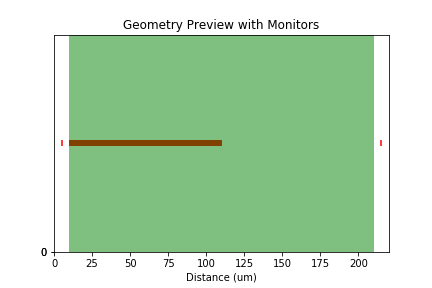

In [5]:
L = 200*L_unit
L_i = 10*L_unit
L_o = 10*L_unit
L_total = L + L_i + L_o

Nmonitors = 500

#deltaM = L/(Nmonitors+1)
#Monitors = L_i + np.linspace(0+deltaM,L-deltaM,Nmonitors)
deltaM = L/2/(Nmonitors+1)
Monitors = L_i + np.linspace(0+deltaM,L/2-deltaM,Nmonitors)
Monitors = np.insert(Monitors,0,L_i/2) #Monitor on the input side
Monitors = np.append(Monitors,L_total-L_o/2) #Monitor on the output side

#
# Visualization of domain and Monitors
#
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axvspan(L_i/L_unit, (L_i+L)/L_unit, facecolor='g', alpha=0.5)
ax.set_xlim(0,L_total/L_unit)
ax.set_ylim(0,1)
ax.set_yticks((0,0))

for k in range(Monitors.size):
    ax.scatter(Monitors[k]/L_unit, 0.5, color='r', marker='|')

ax.axes.set_xlabel("Distance (um)")
ax.margins(0)
ax.set_title('Geometry Preview with Monitors')
fig.canvas.draw()

## Source definition: frequency and pulse shape

For the source we'll use a sech pulse,
$$
p(t) =  \mathrm{sech} \left( \frac{t-t_0}{\tau} \right),
$$
to modulate a carrier at the center frequency $\omega_0$,
$$
E_\mathrm{source}(t) =  E_\mathrm{peak} \, p(t) \sin \left( \omega_0 t \right).
$$

The magnitude of the electric field, $E_\mathrm{peak}$, can be found from the laser intensity,
$$
I = \frac{1}{2}\epsilon_0 c E^2_\mathrm{peak} = \frac{E^2_\mathrm{peak}}{2 \, Z_0}.
$$

In the sech pulse, the parameter $\tau$ controls the bandwidth. In the frequency domain the pulse looks like:
$$
\left| P(\omega) \right| \propto \tau \, \mathrm{sech} \left( \frac{\pi}{2} \omega \tau \right)
$$

In [6]:
wavelen_p = 1.0*L_unit
wavelen_s = 2.0*L_unit
freq_p = c/wavelen_p
freq_s = c/wavelen_s
w_p = 2*pi*freq_p
w_s = 2*pi*freq_s

freq_i = freq_p - freq_s
w_i = 2*pi*freq_i
wavelen_i = c/freq_i

Intensity = 10e12 #W/m^2
Epeak = np.sqrt(2*Intensity/(epsilon_0*c))

def pulse(t,t0,tau): 
    #return np.exp(-((t-t0)/tau)**2) #Gaussian
    return 1/np.cosh((t-t0)/tau)

print("Pump Center Wavelength = ", wavelen_p/L_unit, "um")
print("Signal Center Wavelength = ", wavelen_s/L_unit, "um")
print("Idler Center Wavelength = ", round(wavelen_i/L_unit,2), "um")
print("")
print("Pump Center Frequency = ", round(freq_p/f_unit,2), "THz")
print("Signal Center Frequency = ", round(freq_s/f_unit,2), "THz")
print("Idler Center Frequency = ", round(freq_i/f_unit,2), "THz")
print("")
print("Field Intensity = ", round(Epeak*L_unit,2), "V/um")

Pump Center Wavelength =  1.0 um
Signal Center Wavelength =  2.0 um
Idler Center Wavelength =  2.0 um

Pump Center Frequency =  299.79 THz
Signal Center Frequency =  149.9 THz
Idler Center Frequency =  149.9 THz

Field Intensity =  86.8 V/um


## Grid resolution and time step calculations

For the grid resolution $\Delta z$, we'll consider the following:
- Number of cells per wavelength
- Conformal fitting of the dielectric block

We'll have a vector $z$ that will contain the location of the edges of each cell. The separation between adjacent components is $\Delta z$. In other words,
$$
z_k = k \Delta z, \, (k=0,1,...,N_\mathrm{cells}),
$$
where $N_\mathrm{cells}$ is the number of cells. Note that the vector $z$ has size $N_\mathrm{cells}+1$.

For the time step $\Delta t$, we'll simply use Courant's condition with $S=0.5$,
$$
\Delta t = \frac{\Delta z}{2 c}.
$$
So, in vacuum it will take the field two time steps to propagate over one cell.

It is also convenient to have a vector with the location of the monitors and other geometrical variables in terms of the index variable $k$. So, we'll calculate them here and redraw the geometry using the $k$ discrete variable instead of the physical $z$.

Total number of cells =  22000
Grid resolution (cell size) =  10.0 nm
Total number of time steps =  71950
Time step =  16.68 as


<IPython.core.display.Javascript object>


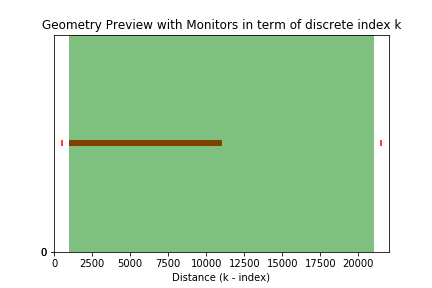

In [7]:
#Grid Resolution
Cells_per_wavelength = 100
dz = wavelen_p/Cells_per_wavelength
Num_cells = round(L_total/dz)
z = np.arange(0,(Num_cells+1)*dz,dz)
print("Total number of cells = ", Num_cells)
print("Grid resolution (cell size) = ", round(dz*1e9,2), "nm")

#Time step
dt = 0.5*dz/c
Total_Time = 1.2*t_unit;
STEPS = round(Total_Time/dt)
t = np.arange(0,STEPS*dt,dt)

print("Total number of time steps = ", STEPS)
print("Time step = ", round(dt*1e18,2), "as")

#Geometry and Monitors in terms of k
x1_k = round(L_i/dz) #Beginning of material
x2_k = round((L_i + L)/dz) #End of material
MonitorsK = np.round(Monitors/dz)
MonitorsK = MonitorsK.astype(int) #Need to cast to integer so it can be used as an index array

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axvspan(x1_k, x2_k, facecolor='g', alpha=0.5)
ax.set_xlim(0,Num_cells)
ax.set_ylim(0,1)
ax.set_yticks((0,0))

for k in range(MonitorsK.size):
    ax.scatter(MonitorsK[k], 0.5, color='r', marker='|')

ax.axes.set_xlabel("Distance (k - index)")
ax.margins(0)
ax.set_title('Geometry Preview with Monitors in term of discrete index k')
fig.canvas.draw()

## Inspecting the source

Now that we have defined the grid resolution and time step, let's take a closer look at the source in both, the time and frequency domain. Let's also look at the total energy contained in the pulse.

We'll first create vectors with the time sequence of the source (electric and magnetic fields).

z_source =  1e-06 um   k_source =  100
tau =  25.0 fs


<IPython.core.display.Javascript object>


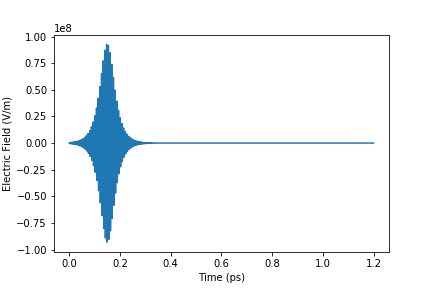

<IPython.core.display.Javascript object>


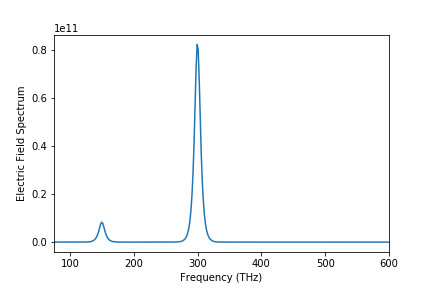

Source Energy from time domain =  1.1406963081372123e+19
Source Energy from frequency domain =  1.1370701040032557e+19


In [8]:
#Location of source    
z_source = 1e-6
k_source = round(z_source/dz)
print("z_source = ",z_source,"um"," ","k_source = ", k_source)

ey_source = np.zeros(STEPS)
hx_source = np.zeros(STEPS)

bandwidth = 40e12 #Aprox
tau = 1/bandwidth
t0 = 6*tau
ey_pump = Epeak*np.sin(w_p*t)*pulse(t,t0,tau)
ey_signal = Epeak*1e-1*np.cos(w_s*t)*pulse(t,t0,tau)

ey_source = ey_pump + ey_signal

print("tau = ", tau*1e15, "fs")

#Calculate frequency domain response
NFFT=6*1024
Nfold=6
EY_source, freq_source = FourierThis(ey_source,dt,NFFT,Nfold)
EY_source = np.abs(EY_source)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e12,ey_source)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Electric Field (V/m)')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq_source*1e-12, EY_source)
ax.set_xlim(0.5*freq_i*1e-12, 2*freq_p*1e-12)
ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Electric Field Spectrum')

#Total energy:
#Time domain
Energy_source_t = np.sum(ey_source**2)
print("Source Energy from time domain = ", Energy_source_t)

#Freq domain
Energy_source_f = FourierEnergy(EY_source)
print("Source Energy from frequency domain = ", Energy_source_f)

## Material Specification

It is usual to model the dispersion of transparent optical materials with Sellmeier's equation:

$$
n^2(\lambda) = 1 + \sum_{k=1}^{m}{\frac{A_k \lambda^2}{\lambda^2 - B_k}},
$$

where we are modeling $m$ independent resonances. Writing this equation in terms of $\omega$ we get:

$$
n^2(\omega) = 1 + \sum_{k=1}^{m}{\frac{\omega_k^2}{\omega_k^2 - \omega^2} \chi_k^{(1)}},
$$

with:

$$
\chi_k^{(1)} = A_k \\
\omega_k = \frac{2\pi c}{\sqrt {B_k}}.
$$

Each one of these equations is the solution of Lorentz Equation:

$$
\frac{d^2P(t)}{dt^2} + \omega_k^2 P(t) = \epsilon_0 \omega_k^2 \, \chi_k^{(1)} E(t).
$$

We'll implement this last equation in FDTD. For the nonlinear case we'll use:

$$
\frac{d^2P(t)}{dt^2} + \omega_k^2 P(t) = \epsilon_0 \omega_k^2 \, \left( \chi_k^{(1)} E(t) +  \chi_k^{(2)} E^2(t) \right).
$$

<IPython.core.display.Javascript object>


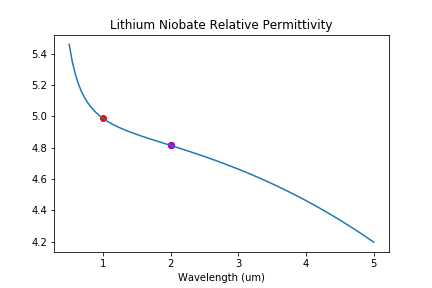

<IPython.core.display.Javascript object>


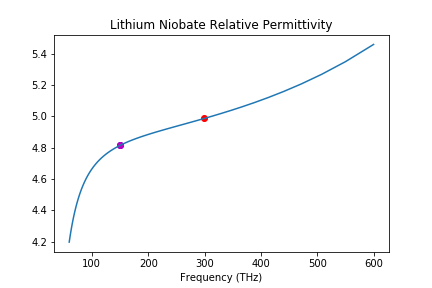

<IPython.core.display.Javascript object>


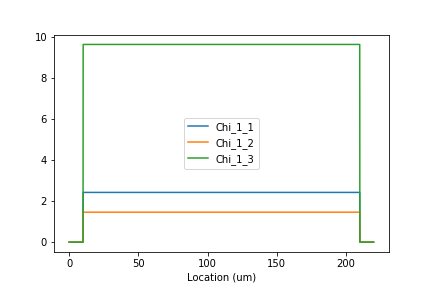

Text(0.5,0,'Location (um)')

In [9]:
#Simple material model
LN_chi_1 = [2.4272, 1.4617, 9.6536]
LN_chi_2 = [30e-12, 0, 0]
LN_wres = [1.5494e16, 7.9514e15, 9.7766e13]

#Dispersion plot
Npoints_plot = 100
wavelength_plot = np.linspace(0.5e-6, 5e-6,  Npoints_plot)
f_plot = c/wavelength_plot
w_plot = 2*pi*f_plot

def n2(chi, w_res, w_eval):
    n = len(chi)
    n2 = 1
    for k in range(n):
        n2 = n2 + chi[k]*w_res[k]**2/(w_res[k]**2 - w_eval**2)
    return n2
    
epsilon_rel = n2(LN_chi_1, LN_wres, w_plot)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wavelength_plot/L_unit, epsilon_rel)
ax.scatter(wavelen_p/L_unit, n2(LN_chi_1, LN_wres, w_p), color='r')
ax.scatter(wavelen_s/L_unit, n2(LN_chi_1, LN_wres, w_s), color='b')
ax.scatter(wavelen_i/L_unit, n2(LN_chi_1, LN_wres, w_i), color='m')
ax.set_title('Lithium Niobate Relative Permittivity')
ax.set_xlabel('Wavelength (um)')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f_plot/f_unit, epsilon_rel)
ax.scatter(freq_p/f_unit, n2(LN_chi_1, LN_wres, w_p), color='r')
ax.scatter(freq_s/f_unit, n2(LN_chi_1, LN_wres, w_s), color='b')
ax.scatter(freq_i/f_unit, n2(LN_chi_1, LN_wres, w_i), color='m')
ax.set_title('Lithium Niobate Relative Permittivity')
ax.set_xlabel('Frequency (THz)')
    
#Vector over the simulation domain
chi_1_1 = np.zeros(Num_cells+1)
chi_1_2 = np.zeros(Num_cells+1)
chi_1_3 = np.zeros(Num_cells+1)

#Lithium Niobate values
#Linear
chi_1_1[x1_k:x2_k] = LN_chi_1[0]
chi_1_2[x1_k:x2_k] = LN_chi_1[1]
chi_1_3[x1_k:x2_k] = LN_chi_1[2]

#Resonance frequencies
w_1 = LN_wres[0]
w_2 = LN_wres[1]
w_3 = LN_wres[2]

#Profile plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z*1e6,chi_1_1,z*1e6,chi_1_2,z*1e6,chi_1_3)
ax.legend(['Chi_1_1','Chi_1_2','Chi_1_3'])
ax.set_xlabel('Location (um)')

## Adding Poling to $ \chi^{(2)} $

The poling period depends on the difference of phase velocities between the harmonic field and the fundamental:

$$
\Delta k = k_p - k_s - k_i = \frac{1}{c} \left( \omega_p n_p - \omega_s n_s - \omega_i n_i \right) .
$$

The optimum poling period is then:
$$
\Lambda = \frac{2 \pi}{\Delta k}
$$

n_wp =  2.23
n_ws =  2.19
n_wi =  2.19
delta_k =  244968.1 1/m
PP =  25.65 um


<IPython.core.display.Javascript object>


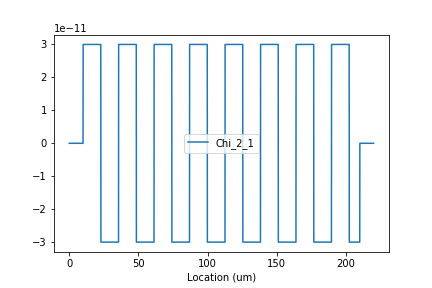

Text(0.5,0,'Location (um)')

In [10]:
#Let's calculate the mismatch and poling period
n_wp = np.sqrt(n2(LN_chi_1, LN_wres, w_p))
n_ws = np.sqrt(n2(LN_chi_1, LN_wres, w_s))
n_wi = np.sqrt(n2(LN_chi_1, LN_wres, w_i))

delta_k = abs(w_p*n_wp-w_s*n_ws-w_i*n_wi)/c
PP = 2*pi/delta_k
print("n_wp = ", round(n_wp,2))
print("n_ws = ", round(n_ws,2))
print("n_wi = ", round(n_wi,2))
print("delta_k = ", round(delta_k,2), "1/m")
print("PP = ", round(PP*1e6,2), "um")

#Vector over the simulation domain
chi_2_1 = np.zeros(Num_cells+1)

#Chi_2
chi_2_1[x1_k:x2_k] = LN_chi_2[0]

#Poled
chi_2_1 = chi_2_1*np.sign(np.sin(2*pi*(z-L_i)/PP))

#Profile plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z*1e6,chi_2_1)
ax.legend(['Chi_2_1'])
ax.set_xlabel('Location (um)')

## Main FDTD Loop

Here we initialize the fields and execute the main time-stepping loop.

In [11]:
#Initialize fields
N_T = Num_cells
ey = np.zeros(N_T+1)
hx = np.zeros(N_T)
jp = np.zeros(N_T+1)

p1 = np.zeros(N_T+1)
jp1 = np.zeros(N_T+1)

p2 = np.zeros(N_T+1)
jp2 = np.zeros(N_T+1)

p3 = np.zeros(N_T+1)
jp3 = np.zeros(N_T+1)

ey_monitor = np.zeros((STEPS, len(MonitorsK)))

#Initialize boundary conditions
ey_0_2 = 0
ey_0_1 = 0
ey_N_2 = 0
ey_N_1 = 0

#Initialize dynamic figure
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()
# fig.canvas.draw()

#Update factors
alpha_h = dt/(dz*mu_0)
alpha_e = dt/(dz*epsilon_0)
alpha_e2 = dt/(epsilon_0)
alpha_j1 = dt*w_1**2
alpha_j2 = dt*w_2**2
alpha_j3 = dt*w_3**2

for n in range(0,STEPS):

    #Magnetic field update
    hx = hx +  alpha_h*(ey[1:]-ey[:N_T])
     
    #Polarization and polarization currents   
    jp1[1:N_T] = jp1[1:N_T] + alpha_j1*(epsilon_0*chi_1_1[1:N_T]*ey[1:N_T] + epsilon_0*chi_2_1[1:N_T]*ey[1:N_T]**2 - p1[1:N_T])
    p1[1:N_T] = p1[1:N_T] + dt*jp1[1:N_T]
    
    jp2[1:N_T] = jp2[1:N_T] + alpha_j2*(epsilon_0*chi_1_2[1:N_T]*ey[1:N_T] - p2[1:N_T])
    p2[1:N_T] = p2[1:N_T] + dt*jp2[1:N_T]
    
    jp3[1:N_T] = jp3[1:N_T] + alpha_j3*(epsilon_0*chi_1_3[1:N_T]*ey[1:N_T]- p3[1:N_T])
    p3[1:N_T] = p3[1:N_T] + dt*jp3[1:N_T]
    
    jp = jp1+jp2+jp3
    
    #Electric field update
    ey[1:N_T] = ey[1:N_T] + alpha_e*(hx[1:] - hx[:N_T-1]) - alpha_e2*jp[1:N_T]

    #Apply source
    ey[k_source] = ey[k_source] + ey_source[n]
    
    #Apply old boundary condition
    ey[0] = ey_0_2
    ey[N_T] = ey_N_2
    
    #Save boundary condition
    ey_0_2 = ey_0_1
    ey_0_1 = ey[1]
    ey_N_2 = ey_N_1
    ey_N_1 = ey[N_T-1]
    
    #Save field at the monitors locations
    ey_monitor[n,:] = ey[MonitorsK]
    
#     if n%100==0:
#         ax.clear()
#         ax.plot(z*1e6,ey)
#         ax.axes.set_ylim(-1.1*Epeak,1.1*Epeak)
#         ax.axvspan(L_i*1e6, (L_i+L)*1e6, facecolor='g', alpha=0.5)
#         #ax.axvline(k_probe*dz*1e6, color='r')
#         ax.axes.set_xlabel("Distance (um)")
#         ax.margins(0)
#         ax.set_title('STEP = %i' % n)
#         fig.canvas.draw()
#         time.sleep(0.001)

<IPython.core.display.Javascript object>


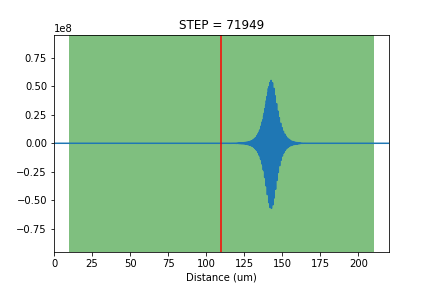

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()

ax.plot(z*1e6,ey)
ax.axes.set_ylim(-1.1*Epeak,1.1*Epeak)
ax.axvspan(L_i*1e6, (L_i+L)*1e6, facecolor='g', alpha=0.5)
ax.axvline(Monitors[-2]*1e6, color='r')
ax.axes.set_xlabel("Distance (um)")
ax.margins(0)
ax.set_title('STEP = %i' % n)
fig.canvas.draw()
time.sleep(0.001)

# Post Processing!

The simulation is complete. Now it is time to look at the field at the monitors in time and frequency domain.

## Field at output of device

C:\Users\luish\AppData\Local\Continuum\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


<IPython.core.display.Javascript object>


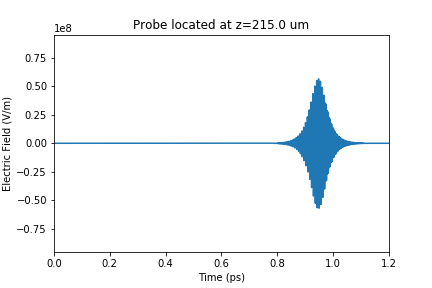

<IPython.core.display.Javascript object>


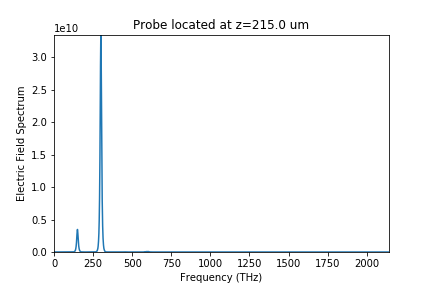

Text(0.5,1,'Probe located at z=215.0 um')

In [13]:
z_output = Monitors[-1]*1e6
e_output = ey_monitor[:,-2]
E_output, freqs = FourierThis(e_output, dt, NFFT=2**16, N=14)
E_output = np.abs(E_output)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e12,e_output)
ax.axes.set_ylim(-1.1*Epeak,1.1*Epeak)
ax.axes.set_xlabel('Time (ps)')
ax.axes.set_ylabel('Electric Field (V/m)')
ax.margins(0)
ax.set_title('Probe located at z=%0.1f um' % z_output)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freqs/1e12,E_output)
#ax.axes.set_ylim(-1.1*Epeak,1.1*Epeak)
ax.axes.set_xlabel('Frequency (THz)')
ax.axes.set_ylabel('Electric Field Spectrum')
ax.margins(0)
ax.set_title('Probe located at z=%0.1f um' % z_output)

## Field Inside the Dielectric

In [14]:
z_output = Monitors[1:-1]*1e6
e_output = ey_monitor[:,1:-1]

E_fp = np.zeros(len(z_output))
E_fs = np.zeros(len(z_output))
E_fi = np.zeros(len(z_output))

for kk in range(len(z_output)):
    E_output, freqs = FourierThis(e_output[:,kk], dt, NFFT=2**16, N=14)
    E_output = np.abs(E_output)
    fp_idx = find_nearest_index(freqs,freq_p)
    fs_idx = find_nearest_index(freqs,freq_s)
    fi_idx = find_nearest_index(freqs,freq_i)
    E_fp[kk] = E_output[fp_idx]
    E_fs[kk] = E_output[fs_idx]
    E_fi[kk] = E_output[fi_idx]

C:\Users\luish\AppData\Local\Continuum\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


4588
2294
2294


<IPython.core.display.Javascript object>


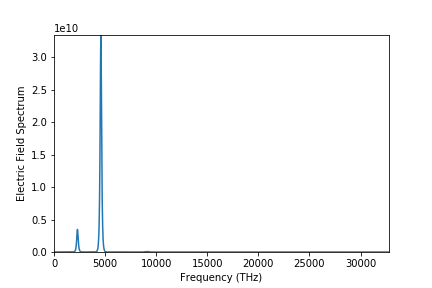

In [15]:
print(fp_idx)
print(fs_idx)
print(fi_idx)
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(freqs/1e12,E_output)
ax.plot(E_output)
ax.axes.set_xlabel('Frequency (THz)')
ax.axes.set_ylabel('Electric Field Spectrum')
ax.margins(0)

<IPython.core.display.Javascript object>


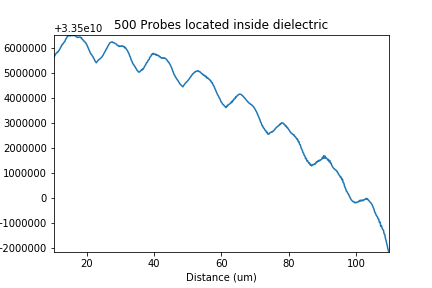

<IPython.core.display.Javascript object>


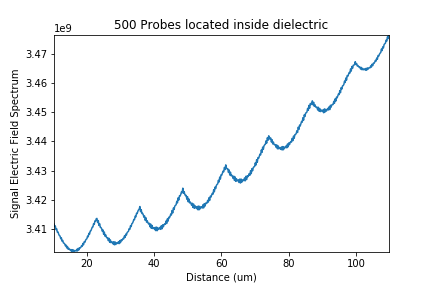

<IPython.core.display.Javascript object>


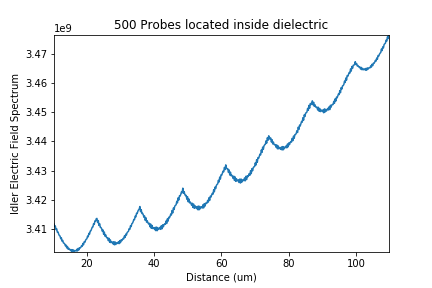

Text(0.5,1,'500 Probes located inside dielectric')

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z_output, E_fp)
#ax.axes.set_ylim(-1.1*Epeak,1.1*Epeak)
ax.axes.set_xlabel('Distance (um)')
ax.axes.set_ylabel('Pump Electric Field Spectrum')
ax.margins(0)
ax.set_title('%i Probes located inside dielectric' % Nmonitors)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z_output, E_fs)
#ax.axes.set_ylim(-1.1*Epeak,1.1*Epeak)
ax.axes.set_xlabel('Distance (um)')
ax.axes.set_ylabel('Signal Electric Field Spectrum')
ax.margins(0)
ax.set_title('%i Probes located inside dielectric' % Nmonitors)
#ax.grid(which='both')
#ax.minorticks_on()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z_output, E_fi)
#ax.axes.set_ylim(-1.1*Epeak,1.1*Epeak)
ax.axes.set_xlabel('Distance (um)')
ax.axes.set_ylabel('Idler Electric Field Spectrum')
ax.margins(0)
ax.set_title('%i Probes located inside dielectric' % Nmonitors)